In [ ]:
# big test of least squares
# 1. import the b0 map
# import b0map as an object
import numpy as np  
import b0
b0map = b0.b0()
filename_to_import_csv_data_from = r'Q:\PTB\cosi-measure\Software\COSI2\data\240619\Thursday_ball_R120_12pts_bvals_shifted.csv'
b0map.import_from_csv(filename_to_import_csv_data_from)
b0map.transfer_coordinates_of_the_path_from_cosi_to_magnet()


# change coordinates to magnet



In [2]:
print(np.nanmin(b0map.b0Data[:,:,:,0]))
print(np.nanmax(b0map.b0Data[:,:,:,0]))

# spherical decomposition
diameter_of_sphere = b0map.path.radius*2
order = 17
resolution_of_sph_decomp = 5
print(diameter_of_sphere)
b0map.fitSphericalHarmonics(maxorder=order,dsv=diameter_of_sphere,resol=resolution_of_sph_decomp)

resolution_of_sph_fit=27
print('interpolating field with sph order %d, resol %.0f mm'%(order,resolution_of_sph_fit))

b0map.interpolateField(resol=resolution_of_sph_fit,dsv=diameter_of_sphere)


-47.809
-47.394
239.91103289828555
(27, 28, 27)
Mean field strength in 23 cm sphere: -47.55 mT
Inhomogeneity in 23 cm sphere: -8727 ppm
Inhomogeneity of fit: 8603 ppm
Error: -863 ppm
saved numpy array as ./data/tmp/SpHData.npy
interpolating field with sph order 17, resol 27 mm
sph coefficients loaded
making a fine coordinate grid
Inhomogeneity of fit: 5759 ppm
saved numpy array as ./data/tmp/B0_interpolated.npy


In [3]:
print('now we have an interpolated field.')
print(np.shape(b0map.interpolatedField))
print('on a coordinate grid')
print(np.shape(b0map.coord_grid_fine))



now we have an interpolated field.
(9, 9, 9)
on a coordinate grid
(3, 9, 9, 9)


In [4]:
print(np.linspace(-0.2295, .2295, 4))
ringspacingouter = 0.085# [m]
print(np.linspace(-ringspacingouter,ringspacingouter,4))

[-0.2295 -0.0765  0.0765  0.2295]
[-0.085      -0.02833333  0.02833333  0.085     ]


let us position some magnets on a circumference of a R=276 mm YZ circle with X=0
336
magnet created, dipole points to  [0. 1. 0.]
HALLO?!
(-0.15749999999999997, 0.27211479674710887, -0.04614691096140277)
x vector length in single magnet simulation:  9
calculating field of one shim magnet at  -0.15749999999999997 0.27211479674710887 -0.04614691096140277
magnet created, dipole points to  [0. 1. 0.]
HALLO?!
(-0.15749999999999997, 0.2742709847847707, -0.030845208788272026)
x vector length in single magnet simulation:  9
calculating field of one shim magnet at  -0.15749999999999997 0.2742709847847707 -0.030845208788272026
magnet created, dipole points to  [0. 1. 0.]
HALLO?!
(-0.15749999999999997, 0.27556740718070843, -0.015446815196073495)
x vector length in single magnet simulation:  9
calculating field of one shim magnet at  -0.15749999999999997 0.27556740718070843 -0.015446815196073495
magnet created, dipole points to  [0. 1. 0.]
HALLO?!
(-0.15749999999999997, 0.276, 0.0)
x vector length

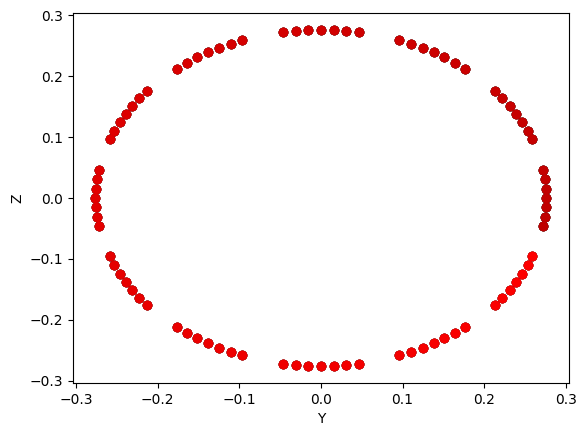

In [78]:
# shim magnets positinoing

mu                  = 1e-7

magSizeOuter        = 6*1e-3        #size of shim magnets
bRem                = 1.35 # [T]      #remanence field of shim magnets

#shim tray configuration
def ringposFromTrayNr(trays_ocp):
    trayslitspacing = 9e-3 # [m]
    coordinates = []
    for tray_pos in trays_ocp:
        coordinate = trayslitspacing*tray_pos-4.5e-3 if tray_pos>0 else trayslitspacing*tray_pos+4.5e-3
        coordinates.append(coordinate)
    return coordinates


shimRadius          = 276*1e-3#276*1e-3 <- was set by Tom!      # radius on which the shim magnets are placed

trays_occupied = [-18,-5,1,12] #[-18,-5,1,12] 1179
ringPositions       = ringposFromTrayNr(trays_occupied)#[-121.5*1e-3, -40.5*1e-3, 31.5*1e-3, 121.5*1e-3]#np.linspace(-ringspacingouter,ringspacingouter,4)#np.linspace(-0.1755,0.1755,4)          #np.linspace(-0.2295, .2295, 4) #Z positions to place shin rubgs
#print(ringPositions)
magsPerSegment      = 7             # number of magnets peer shim tray segment
anglePerSegment     = 19.25 #the angular distance in degrees between the furthest magnets in a shim tray (span of magnets in shim tray)
numSegments         = 12 #corresponds to the number of shim trays


segmentAngles       = np.linspace(0,360, numSegments, endpoint = False)

magAngles           = np.linspace(-anglePerSegment/2, anglePerSegment/2, magsPerSegment) 

print('let us position some magnets on a circumference of a R=%.0f mm YZ circle with X=0'%(shimRadius*1000))

positions = []
for ringPosition in ringPositions:
    for segmentAngle in segmentAngles:
        for magAngle in magAngles:
            # the most important line is this. Our bore is along X, so we create an array of positions along X, not along Z!
            #positions.append((shimRadius*np.cos((segmentAngle+magAngle)*np.pi/180), shimRadius*np.sin((segmentAngle+magAngle)*np.pi/180), ringPosition))
            positions.append((ringPosition,shimRadius*np.cos((segmentAngle+magAngle)*np.pi/180), shimRadius*np.sin((segmentAngle+magAngle)*np.pi/180)))

        # check if rings are in the right plane
        #print(positions) 

print(len(positions))

import matplotlib.pyplot as plt
for idx,position in enumerate(positions):

    plt.scatter(position[1],position[2],color = [idx/len(positions),0,0])

plt.xlabel('Y')
plt.ylabel('Z')


initialField = b0map.interpolatedField
numMags = len(positions)
coordinate_grid = b0map.coord_grid_fine

magnetFields = np.zeros((np.shape(initialField)+(3,numMags)), dtype = np.float32)

def magnetization(bRem, dimensions, shape = 'cube', evalDistance = 1):
    #Use the analytical expression for the z component of a cube magnet to estimate
    #dipole momentstrength for correct scaling. Dipole approximation only valid 
    #far-ish away from magnet, comparison made at 1 meter distance.
    if shape == 'cube':
        b_analytic = (bRem/np.pi) *(np.arctan2(dimensions**2, 2*evalDistance *np.sqrt(4*(evalDistance**2) + 2*(dimensions**2)))-\
                        np.arctan2(dimensions**2, 2*(dimensions + evalDistance)*\
                                   np.sqrt(4*((dimensions+evalDistance)**2)+2*(dimensions**2))))
    
        dip_mom = b_analytic * (dimensions/2 + evalDistance)**3 /(2*mu) #strength of the dipole moment
    
    return dip_mom

from utils import shimming_magnet

shimming_magnets = []

DSV = b0map.path.radius*2

dip_mom = magnetization(bRem=bRem,dimensions=magSizeOuter)
dip_vec = mu*np.array([0,dip_mom,0]) #initially along y

for idx1, position in enumerate(positions):
    magnet = shimming_magnet.shimming_magnet(position=position,rotation_yz=0)
    #magnetFields[:,:,:,:,idx1] = magnet.singleMagnet(position, grid=coordinate_grid)
    magnetFields[:,:,:,:,idx1] = magnet.OLD_singleMagnet(position=position,dipoleMoment = dip_vec, 
                                                         simDimensions=[DSV*1e-3,DSV*1e-3,DSV*1e-3],
                                                         resolution=1/resolution_of_sph_fit*1e3,
                                                         plotFields=False)[:,:,:,:] #singleMagnet(position, grid=coordinate_grid)

    shimming_magnets.append(magnet)

magnetFields *= 1e3

print(DSV)


In [79]:
# visualize the field of one magnet
resolution = 1/resolution_of_sph_fit*1e3

X = b0map.xDim_SPH_fine*1e0
Y = b0map.yDim_SPH_fine*1e0
Z = b0map.zDim_SPH_fine*1e0

ONEMAGNETFIELD = magnetFields[:,:,:,:,0]*0

#ax = plt.figure().add_subplot()
for idx in range(0,336,1):

    position = positions[idx]

    x,y,z = coordinate_grid
    y2d, z2d = np.meshgrid(Y,Z,indexing='xy')

    ONEMAGNETFIELD += magnetFields[:,:,:,:,idx]#+magnetFields[:,:,:,:,idx+14]

    
    
    
    #ax.plot(position[1]*1000,position[2]*1000,'x')
scale = 5e-0
yzsliceindex = 3
# ax.contourf(y2d,z2d,ONEMAGNETFIELD[yzsliceindex,:,:,2],cmap='coolwarm',levels=64)#,vmin = -scale, vmax= scale)

# ax.plot(min(Y),min(Z),'ko')
# ax.plot(max(Y),max(Z),'ko')

# ax.set_xlabel('Y')
# ax.set_ylabel('Z')
# ax.set_xlim(-290,290)
# ax.set_ylim(-290,290)
# ax.set_aspect(1)
                
# ax.set_title('z component of field of magnet at [%.2e,%.2e,%.2e] YZ plane, X= %.2f'%(position[0]*1e3,position[1]*1e3,position[2]*1e3,X[yzsliceindex]))

# plt.show()

In [80]:
# mask the magnet fields
# DSV = b0map.path.radius*2 # DEFINED ABOVE!
# make a spherical mask with diameter DSV
sphereMask = np.zeros(np.shape(coordinate_grid[0]), dtype = float)
sphereMask[np.square(coordinate_grid[0]) + np.square(coordinate_grid[1]) + np.square(coordinate_grid[2]) <= (DSV/2)**2] = 1 
sphereMask[sphereMask == 0] = np.nan

print(np.shape(magnetFields))

maskedFields = magnetFields[sphereMask == 1, :,:].astype(float)
maskedFields_stacked = np.hstack((maskedFields[:,1,:],maskedFields[:,2,:])) # WE HAVE Y AND Z


#plt.imshow(maskedFields_stacked) #



(9, 9, 9, 3, 336)


In [81]:
# masking the magnet fields

print(np.shape(maskedFields_stacked))

vector_of_magnet_rotations = np.zeros(len(shimming_magnets))

stackedRotationVector = np.hstack([np.cos(vector_of_magnet_rotations),np.sin(vector_of_magnet_rotations)])
print(np.shape(stackedRotationVector))

rotatedFieldOfShimMagnetsStacked = np.matmul(maskedFields_stacked,stackedRotationVector)

print(np.shape(rotatedFieldOfShimMagnetsStacked))


(257, 672)
(672,)
(257,)


In [82]:
#plt.imshow(initialField[1,:,:])

initialFieldMasked = initialField[sphereMask == 1]
print(np.shape(initialFieldMasked))
print(np.shape(initialField))

(257,)
(9, 9, 9)


In [83]:
# ok now we have magnet fields and vector of magnet rotations. we can make fields now
def _dataFitting(shimVector):
            #factor = 1+np.random.randint(10)/1000
            #shimVector = shimVector*factor
            stackedRotationVector = np.hstack([np.cos(shimVector),np.sin(shimVector)])
            shimField = np.matmul(maskedFields_stacked*1.00,stackedRotationVector)+initialFieldMasked
            #optimizedField = np.matmul(magnetFields[...,1,:], np.cos(shimVector)) + np.matmul(magnetFields[...,2,:], np.sin(shimVector))
            #shimField = optimizedField + initialField
            #shimField[np.isnan(shimField)] = np.nanmean(shimField)*1
            shimField = shimField[~np.isnan(shimField)]
            

            #shimField = shimField.flatten()

            return np.square(((shimField)/np.mean(shimField)) -1)*1e9


In [84]:
#render the field of rotated magnets
optimized_vector_of_magnet_rotations = np.zeros(len(shimming_magnets))#+np.pi/4*8.05#np.random.randint(40)*2*np.pi/40
#optimized_vector_of_magnet_rotations = np.load('opt1e3.npy')
shimming_magnets[0].render_field(coordinate_grid)
shimFieldRendered = shimming_magnets[0].B0*0

for idx, magnet in enumerate(shimming_magnets):
    alpha = optimized_vector_of_magnet_rotations[idx]
    magnet.rotation_yz = alpha
    magnet.render_field(grid=coordinate_grid)
    shimFieldRendered += magnet.B0

#plt.imshow(shimFieldRendered[2,:,:,2])


In [85]:
# now do the least squares optimization
vector_of_magnet_rotations =np.load('opt1e3.npy')#
#vector_of_magnet_rotations = np.zeros(len(shimming_magnets))#vector_of_magnet_rotations*0 ##
cost = _dataFitting(vector_of_magnet_rotations)

print(np.sum(cost))

# least squares optimization of the rotation vector
from scipy.optimize import least_squares

initialGuess = vector_of_magnet_rotations
#initialGuess[initialGuess<0.001] = 0.001
lsqData = least_squares(_dataFitting, initialGuess, max_nfev=6400, xtol = 1e-5,ftol=0, verbose=2,bounds=(initialGuess*0,initialGuess*0+2*np.pi))


7161.065902921574
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.2925e+05                                    3.51e+05    
       1              2         5.6810e+05      6.12e+04       8.95e-01       2.24e+05    
       2              3         5.3271e+05      3.54e+04       4.25e-01       1.15e+05    
       3              4         5.2181e+05      1.09e+04       2.70e-01       8.11e+04    
       4              5         5.1755e+05      4.26e+03       1.54e-01       5.67e+04    
       5              6         5.1553e+05      2.02e+03       1.30e-01       3.38e+04    
       6              7         5.1436e+05      1.17e+03       8.37e-02       3.42e+04    
       7              8         5.1363e+05      7.30e+02       8.09e-02       1.98e+04    
       8              9         5.1306e+05      5.68e+02       6.02e-02       2.59e+04    
       9             10         5.1260e+05      4.68e+02       6.47e-02 

[3.75307587e+00 3.38464128e+00 3.00083536e+00 2.62201556e+00
 6.28305952e+00 6.28310948e+00 6.28311092e+00 4.57458523e-01
 8.91934573e-02 3.67957457e-06 2.11436214e-07 2.00826259e-12
 9.38041483e-18 1.33552381e-19 1.13624585e-23 5.48387493e-24
 7.92679027e-24 3.42339458e-23 4.19660662e-22 3.70457202e+00
 3.56720169e+00 3.15825523e+00 3.05631908e+00 2.96560385e+00
 2.88699603e+00 2.82037131e+00 2.76427444e+00 2.71620360e+00
 2.54707194e+00 2.47343027e+00 6.28318531e+00 2.27260122e+00
 2.14255043e+00 1.99411708e+00 1.82397992e+00 1.05713316e+00
 7.28382346e-01 3.17437787e-01 5.05441671e-03 5.54059507e+00
 5.04684647e+00 4.64230563e+00 3.66260166e+00 3.41296467e+00
 3.16762661e+00 2.92264567e+00 2.67507188e+00 2.42276539e+00
 2.16227230e+00 1.20423908e+00 8.86689856e-01 5.61033589e-01
 2.32821510e-01 1.97038538e-04 2.94012438e-09 5.00391899e-14
 2.85633928e-32 2.43609086e-33 5.24640164e-37 6.70939128e-33
 8.86191761e-33 3.96973106e+00 3.83055484e+00 3.40390992e+00
 3.28383723e+00 3.164716

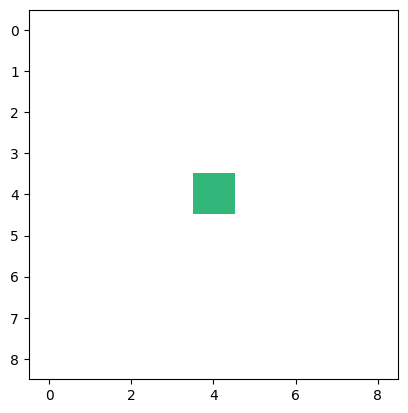

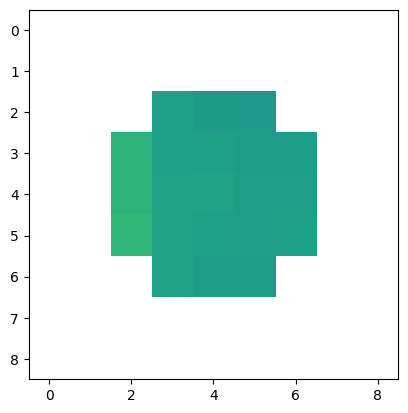

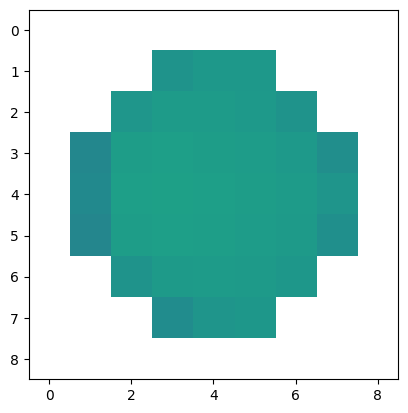

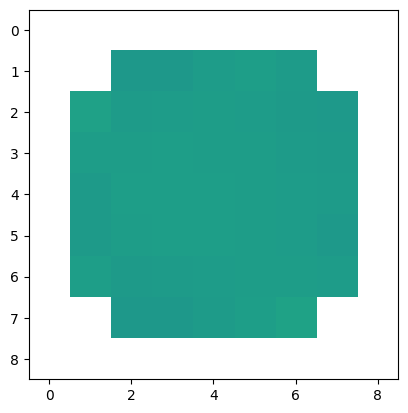

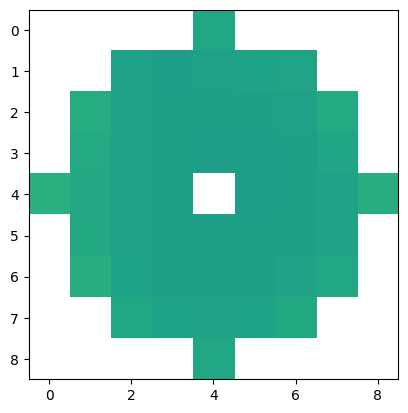

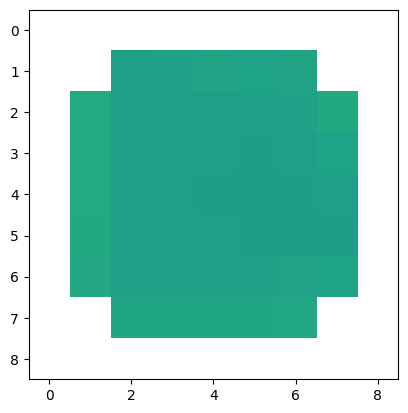

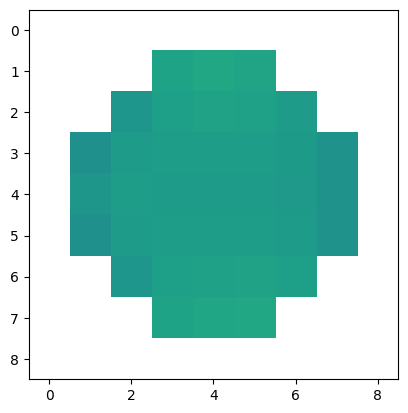

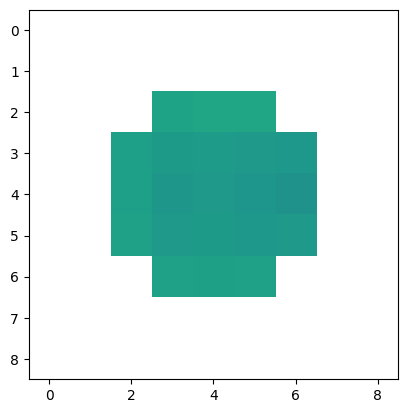

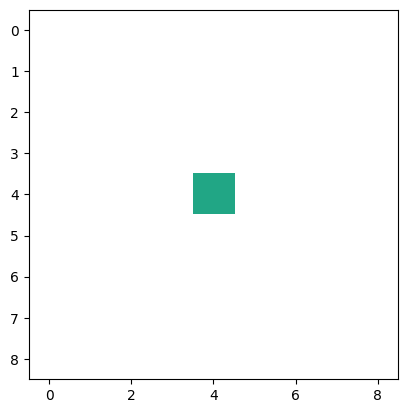

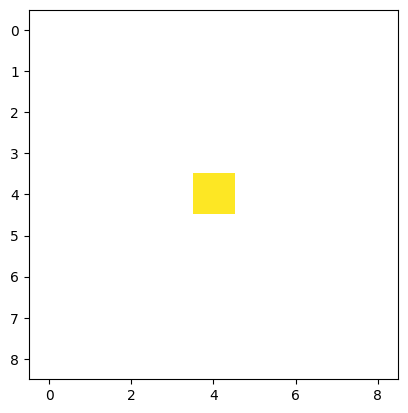

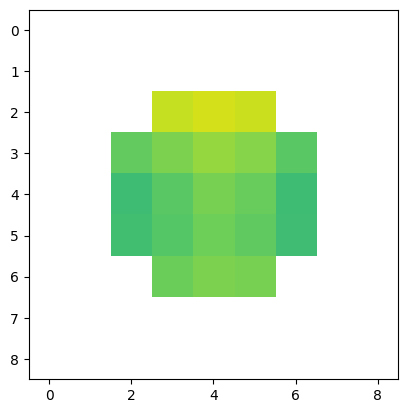

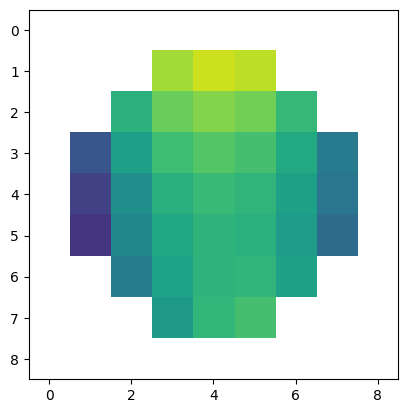

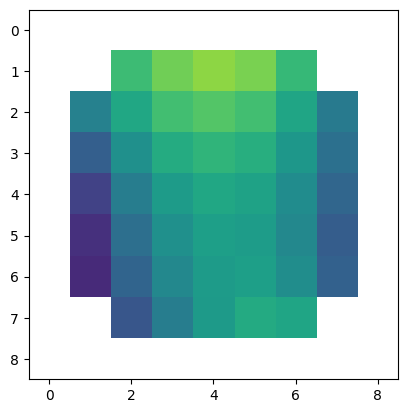

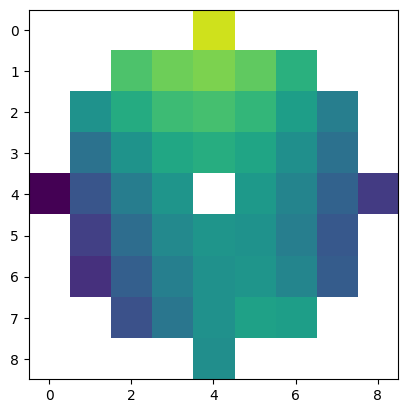

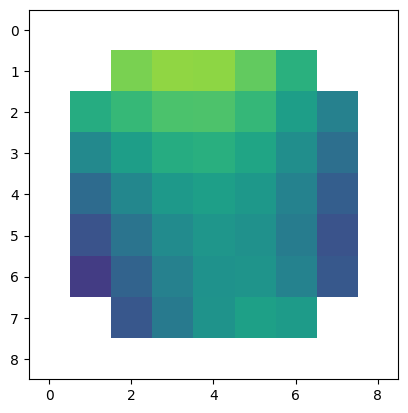

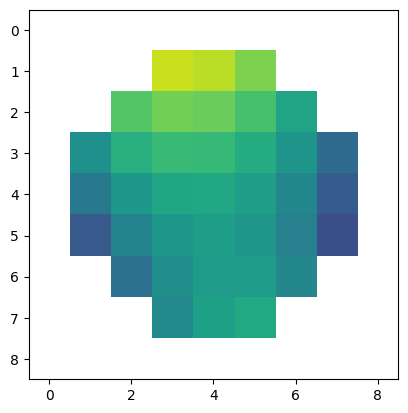

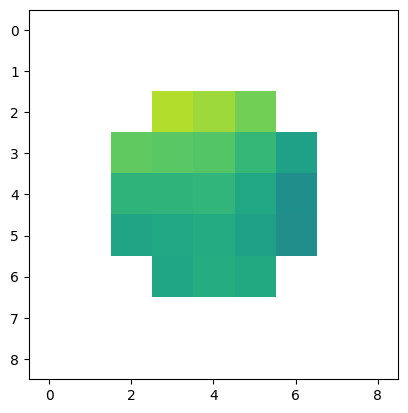

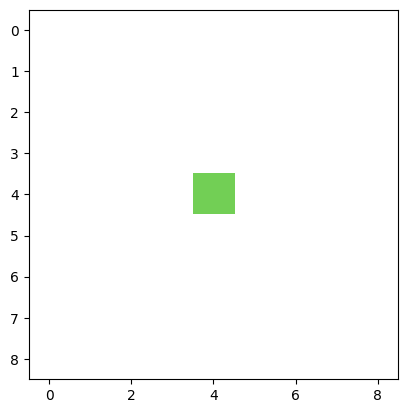

In [86]:
optimized_vector_of_magnet_rotations = lsqData.x
np.save('opt1e3',optimized_vector_of_magnet_rotations)
#np.save('opt336magnets_27mm_1607ppm',optimized_vector_of_magnet_rotations)

print(optimized_vector_of_magnet_rotations)

shimFieldRendered = shimming_magnets[0].B0*0

for idx, magnet in enumerate(shimming_magnets):
    alpha = optimized_vector_of_magnet_rotations[idx]
    magnet.rotation_yz = alpha
    magnet.render_field(grid=coordinate_grid)
    shimFieldRendered += magnet.B0

shimField = initialField[:,:,:]*1+shimFieldRendered[:,:,:,2]*1 #???? why 1st not 2nd component!?!!s


optimizedField = np.matmul(magnetFields[...,1,:], np.cos(lsqData.x)) + np.matmul(magnetFields[...,2,:], np.sin(lsqData.x))
print(np.shape(optimizedField))




shimField = initialField+optimizedField

homoinit = (np.nanmax(initialField)-np.nanmin(initialField))/np.nanmean(initialField)*1e6
homo = (np.nanmax(shimField)-np.nanmin(shimField))/np.nanmean(shimField)*1e6
print('inhomogeneity ppm %.0f -> %.0f'%(abs(homoinit),abs(homo)))
print('mean mT %.2f -> %.2f'%(abs(np.nanmin(initialField)),abs(np.nanmin(shimField))))


shimoffset = np.nanmean(shimField) - np.nanmean(initialField)
d = np.shape(coordinate_grid[0])
print(d[0])
for i in range(d[0]):
    plt.imshow(shimField[i,:,:],clim=[np.nanmin(initialField)+shimoffset,np.nanmax(initialField)+shimoffset])
#plt.imshow(optimizedField[:,:,13])
    plt.show()


for i in range(d[0]):
    plt.imshow(initialField[i,:,:],clim=[np.nanmin(initialField),np.nanmax(initialField)])
#plt.imshow(optimizedField[:,:,13])
    plt.show()

#plt.imshow(initialField[5,:,:],clim=[np.nanmin(initialField),np.nanmax(initialField)])

#plt.imshow(magnetFields_rotated_summed[10,:,:])

In [67]:
# now making a gif
from PIL import Image
import glob
import time

# create an empty list called images
images = []

# get the current time to use in the filename
timestr = time.strftime("%Y%m%d-%H%M%S")

# get all the images in the 'images for gif' folder
for idx in range(127): # loop through all png files in the folder
    filename = './pics/%d.png'%idx
    im = Image.open(filename) # open the image
    #im_small = im.resize((1080, 70), resample=1) # resize them to make them a bit smaller
    images.append(im) # add the image to the list

# calculate the frame number of the last frame (ie the number of images)
last_frame = (len(images)) 

# create 10 extra copies of the last frame (to make the gif spend longer on the most recent data)
#for x in range(0, 9):
#    im = images[last_frame-1]
#    images.append(im)

# save as a gif   
images[0].save('./gifs/sixteen_magnets_same_side_orth'+timestr+'.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=50, loop=0)

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_axes(111)#,projection='3d')  
#ctrf = ax.plot_surface(y2,z2,fld,cmap='viridis',edgecolor='black')#zdir = 'x', offset = fld, alpha=0.5,cmap='viridis',edgecolor='black',vmin = np.nanmin(fld), vmax = np.nanmax(fld),levels=64)
minval_of_b0 = np.nanmin(shimField)
maxval_of_b0 = np.nanmax(shimField)

idx = 70
#fld_slc = fld[idx,:,:]
fld_slc=shimField[idx,:,:]
ax.cla()
ax.contourf(y2,z2,fld_slc, offset = 0, alpha=0.5,cmap='viridis',edgecolor='black',vmin = minval_of_b0/1e4, vmax = maxval_of_b0/1e4,levels=64)
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Shim Magnets Field X=%.2f, angles = %.2f deg'%(X[idx],angleofrotation*180/np.pi))

#plt.xlim(-100,100)
#plt.ylim(-100,100)


plt.show()


In [ ]:
print('lets mask out the fields')
import scipy.ndimage as cp # for erosion

def cartToSpher(coords):
    r = np.sqrt(np.sum(np.square(coords),axis = -1))    
    #remove r = 0 to avoid divide by zero
    r[r==0] = np.nan
    
    phi = np.arctan2(coords[...,0], coords[...,1]) + np.pi
    theta = np.arccos(coords[...,2]/r)
    return np.stack([r,theta, phi], axis = -1)

xDim = X
yDim = Y
zDim = Z

xDim3D, yDim3D, zDim3D = np.meshgrid(xDim, yDim, zDim, indexing = 'ij')
spherCoord = cartToSpher(np.stack((xDim3D,yDim3D, zDim3D), axis = -1))

#Apply mask to data
DSV_mask = 246#e-3

mask = (np.round(spherCoord[...,0],4) <= (DSV_mask/2)).astype(float)
halfMask = mask #*((zDim3D<=0).astype(float))
erodedMask = cp.binary_erosion(halfMask.astype(bool))                    # remove the outer surface of the initial spherical mask
halfMask = np.array(halfMask.astype(bool)^erodedMask, dtype = float)   # create a new mask by looking at the difference between the inital and eroded mask
halfMask[halfMask == 0] = np.nan    
mask[mask == 0] = np.nan



In [ ]:
print('Echo Test')
import numpy as np

initialGuess = np.load('vector_of_magnet_rotations.npy')
fldsZ = np.load('fldsZ.npy')
fldsY = np.load('fldsY.npy')
interpolatedField_masked = np.load('interpolatedField_masked.npy')

def _calculate_shimming_error(vector_of_magnet_rotations):
            '''calculate the shim field of shim magnets that are turned as vector_of_magnet_rotations says'''
            cheapField = np.matmul(fldsZ,np.cos(vector_of_magnet_rotations)) + np.matmul(fldsY,np.sin(vector_of_magnet_rotations)) + interpolatedField_masked
            cheapField = cheapField[~np.isnan(cheapField)]

            return np.square((cheapField/np.mean(cheapField)-1))*1e9
        

from scipy.optimize import least_squares


lsqData = least_squares(_calculate_shimming_error, initialGuess, ftol=1e-32, xtol=0, max_nfev=10000, verbose=2, bounds=(initialGuess*0,initialGuess*0+2*np.pi))

optimized_rotation_vector = lsqData.x

totfield = np.matmul(fldsZ,np.cos(optimized_rotation_vector)) + np.matmul(fldsY,np.sin(optimized_rotation_vector)) + interpolatedField_masked

newhomo = (np.nanmax(totfield)-np.nanmin(totfield))/np.nanmean(totfield)*1e6
print('new homo: %.0f ppm'%newhomo)


def save_rings(fname:str):
        print('save magnet positions and rotations to the file')
        with open(fname, 'w') as file:
            file.write('x[m],y[m],z[m],dirx[m^2A],diry[m^2A],dirz[m^2A],rotation_xy[rad]\n')
            for alpha in optimized_rotation_vector:
                 x=0
                 y=0
                 z=0
                 dirx = 0
                 diry = 0
                 dirz = 0     
                 rot  = alpha

                 file.write('%.4f,%.4f,%.4f,%.4e,%.4e,%.4e,%.4f\n'%(x,y,z,dirx,diry,dirz,rot))
        file.close()
        print('exported magnet rotations/positions as *txt file')

save_rings('output_angles_in_ring_format.txt')


